# Run to Failure degradation simulation of NASA Turbo Jet Engine Fans

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import QuantileTransformer , PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from keras import optimizers
from keras.models import Sequential
from keras.layers import TimeDistributed, Flatten
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

from keras.models import load_model
import pickle

In [27]:
train_file = "train_FD001.txt" 
test_file = "test_FD001.txt"
RUL_file = "RUL_FD001.txt"

In [28]:
log_model = pickle.load(open('logistic_regression.sav', 'rb'))
lin_model = pickle.load(open('linear_regression.sav', 'rb'))
forest_model = pickle.load(open('forest_regression.sav', 'rb'))

In [29]:
df_test = pd.read_csv(test_file, sep=" ",header=None)
df_test.drop(columns=[26,27],inplace=True)
columns = ["Section-{}".format(i)  for i in range(26)]
df_test.columns = columns
# df_test.head()

In [30]:
df_test_rul = pd.read_csv(RUL_file, names=['rul'])
# df_test_rul.head()

In [31]:
RUL_name = ["Section-1"]
RUL_data = df_test[RUL_name]
MachineID_series = df_test["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])

In [32]:
df_test.drop(df_test[["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"]], axis=1 , inplace=True)
#df_test = df_test.groupby(["Section-0"])
#print(df_test)


In [33]:
gen = MinMaxScaler(feature_range=(0, 1))
df_test = gen.fit_transform(df_test)
df_test = pd.DataFrame(df_test)
#df_test = df_test.rolling(20).mean()
pt = PowerTransformer()
df_test = pt.fit_transform(df_test)
df_test=np.nan_to_num(df_test)

In [34]:
test_data = []
i = 0
count = 0
while i < len(df_test):
    temp = []
    j = int(max_cycles[count])
    count = count+1
    #print(j)
    if j == 0:
        break
    while j!=0:
        temp.append(df_test[i])
        i=i+1
        j=j-1
    test_data.append(temp)

In [35]:
print(len(test_data))

100


In [36]:
y_new = []
for i in range(len(test_data)):
    y_new.append(pd.DataFrame(test_data[i]))

y_new[1]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-1.793850,-0.403908,1.327938,0.491476,0.264432,0.414832,-0.930599,0.549425,-2.091438,0.139549,-0.291073,1.195698,-0.972686,0.128797,-0.435852,0.748684,0.655920
1,-1.759832,-0.494678,0.677007,0.124510,0.091941,0.167868,-0.390194,0.039405,-0.328605,0.240686,0.447638,0.209360,-2.364091,0.569061,0.378493,-0.405454,-0.574031
2,-1.726093,0.095455,1.004600,0.297019,1.470300,0.931735,-0.658122,1.031562,-2.687990,0.240686,-0.852788,0.209360,-1.352862,-1.645776,1.148940,0.899581,0.835040
3,-1.692628,1.140251,0.344897,-0.381088,-0.930734,0.567578,0.546454,1.186557,-1.118874,0.088446,-0.378925,-0.143646,-0.931472,0.329208,0.378493,-0.543059,1.669632
4,-1.659435,0.186271,-1.395065,0.754319,-0.597428,0.477975,0.280052,1.031562,-1.535407,0.340425,-0.343903,0.715408,-1.316947,0.004742,-0.435852,-0.611304,0.620619
5,-1.626511,-0.358520,-1.035151,0.099683,-1.694581,-0.320162,-0.009098,0.713093,-1.742885,0.956764,0.033405,-0.143646,-1.073174,-0.222763,-0.435852,-0.813804,-0.816911
6,-1.593852,0.867611,0.007977,0.418886,1.223617,0.154514,-0.347077,1.186557,-0.729036,0.583861,-1.357336,0.034494,-1.308691,-0.469407,0.378493,-1.012946,2.391391
7,-1.561456,0.685883,1.004600,0.370273,-0.972818,0.034889,-0.903790,0.039405,-0.677335,0.036981,-0.112400,1.350488,-0.355285,0.621678,-1.300958,-0.746677,-1.308672
8,-1.529320,-0.993778,1.004600,-0.458622,0.153580,0.469392,-0.781945,0.382663,-0.596323,0.340425,-0.534577,0.209360,-0.730091,0.716429,-0.435852,-1.273230,-0.769650
9,-1.497440,0.958485,1.327938,0.174027,0.571892,0.251963,-0.504089,0.873772,-0.308210,0.340425,-1.172699,0.549714,-1.790488,-0.120693,-0.435852,0.159801,0.009971


In [51]:
predictions = []
for i in range(len(y_new)):
    test_model = VAR(y_new[i])
    test_model_fit = test_model.fit()
    test_pred = test_model_fit.forecast(test_model_fit.y, steps=1)
    predictions.append(test_pred)

In [52]:
predictions[0].shape

(1, 17)

In [53]:
logistic_pred = []
for i in range(100):
    logistic_pred.append(log_model.predict(predictions[i]))

In [54]:
logistic_pred = np.array(logistic_pred)

In [55]:
len(logistic_pred)

100

In [56]:
y_test = np.array(df_test_rul)

In [57]:
len(y_test)

100

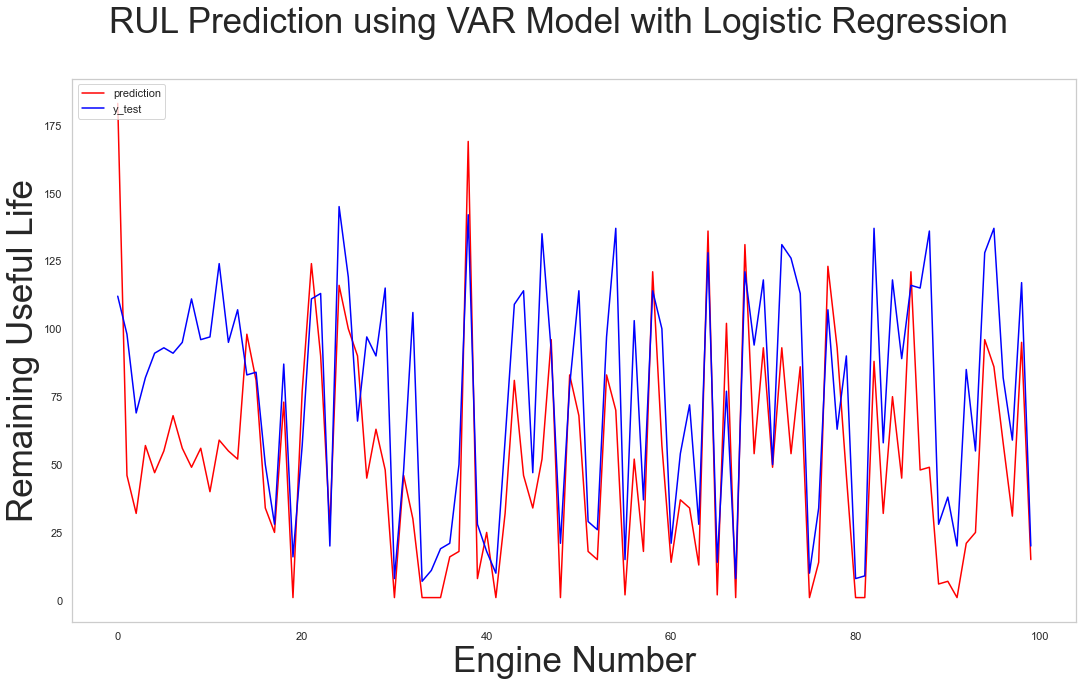

In [58]:
fig = plt.figure(figsize=(18,10))
plt.plot(logistic_pred,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')

fig.suptitle('RUL Prediction using VAR Model with Logistic Regression', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)

plt.legend(loc='upper left')
plt.grid()
plt.show()

Text(0, 0.5, 'Remaining Useful Life')

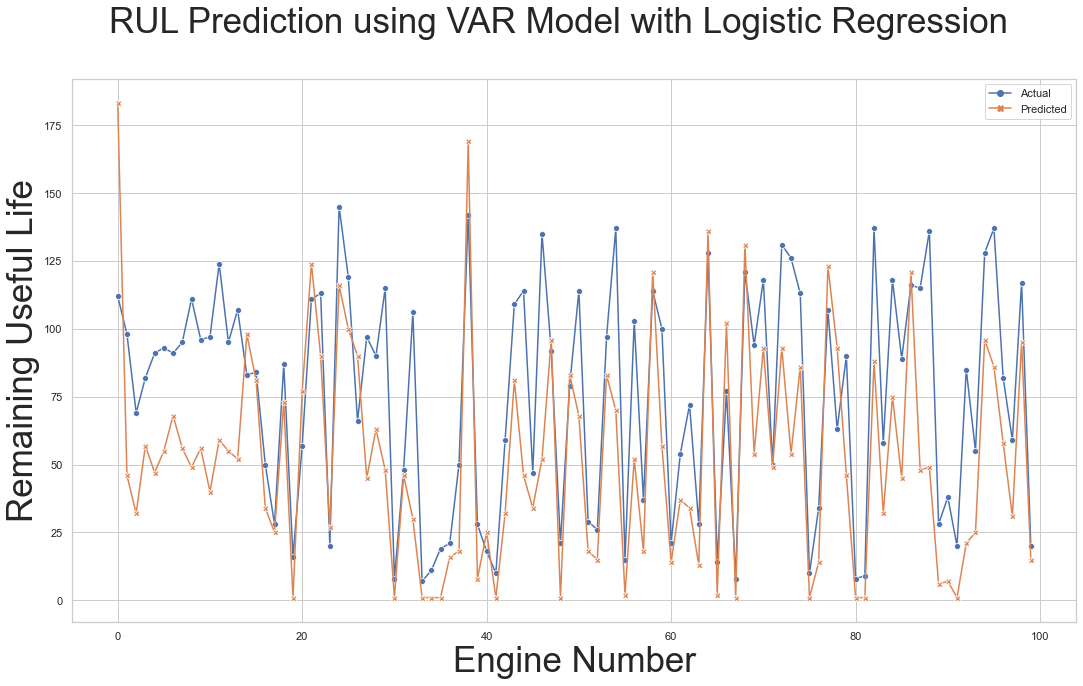

In [59]:
df=pd.DataFrame(np.arange(1,101))
df['Actual']=y_test
df['Predicted']=logistic_pred
df=df.drop([0],axis=1)

sns.set_theme(style="whitegrid")
a4_dims = (18,10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df,markers=True, dashes=False)

fig.suptitle('RUL Prediction using VAR Model with Logistic Regression', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)

In [60]:
def scoring_function(actual,predicted):
    d = []
    for i in range(len(predicted)):
        d.append((predicted[i] - actual[i]))
    scores = []
    for i in range(len(d)):
        if d[i] >= 0:
            scores.append(math.exp(d[i]/10) - 1)
        else :
            scores.append(math.exp((-1*d[i])/13) - 1)
    return sum(scores)

print("mean_squared_error >> ", mean_squared_error(y_test,logistic_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,logistic_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_test,logistic_pred))
print("scoring function >>",scoring_function(y_test,logistic_pred))

mean_squared_error >>  1262.74
root_mean_squared_error >>  35.535053116605866
mean_absolute_error >> 28.68
scoring function >> 5285.391201712641


# 2. Linear Regression with VAR

100
100


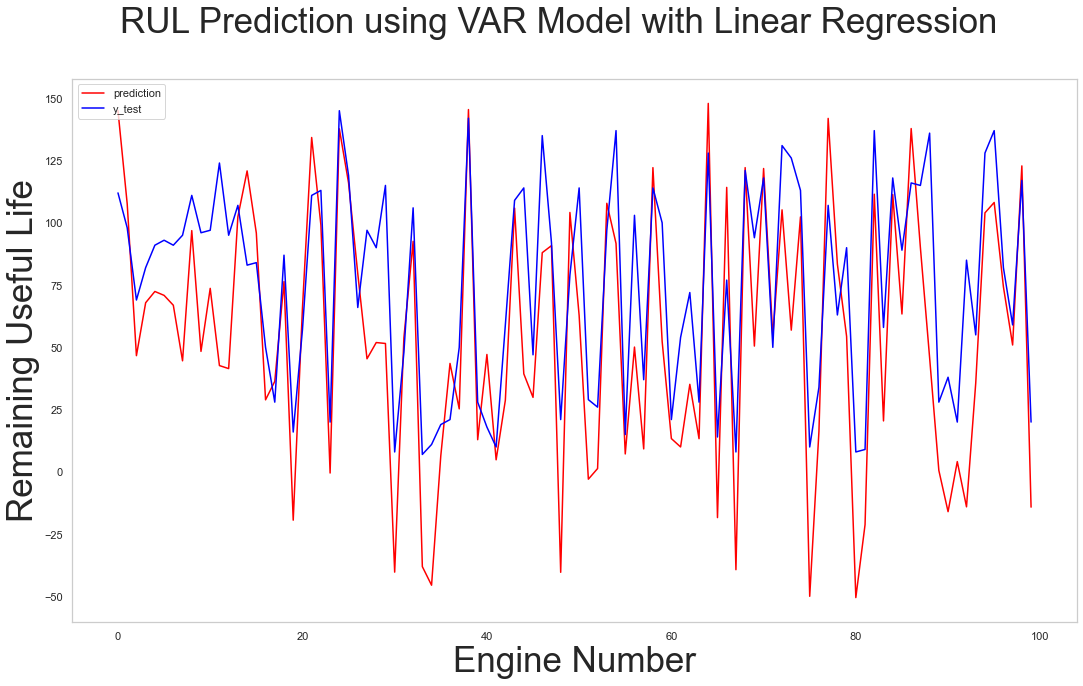

(100, 1)
mean_squared_error >>  1233.9732305945167
root_mean_squared_error >>  35.12795511547059
mean_absolute_error >> 28.485480968897164
scoring function >> 5721.583542295491


In [61]:
lin_pred = []
for i in range(100):
    lin_pred.append(lin_model.predict(predictions[i]))

lin_pred = np.array(lin_pred)

print(len(lin_pred))

y_test = np.array(df_test_rul)

print(len(y_test))
lin_pred = lin_pred.reshape((100,1))

fig = plt.figure(figsize=(18,10))
plt.plot(lin_pred,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')

fig.suptitle('RUL Prediction using VAR Model with Linear Regression', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)

plt.legend(loc='upper left')
plt.grid()
plt.show()

def scoring_function(actual,predicted):
    d = []
    for i in range(len(predicted)):
        d.append((predicted[i] - actual[i]))
    scores = []
    for i in range(len(d)):
        if d[i] >= 0:
            scores.append(math.exp(d[i]/10) - 1)
        else :
            scores.append(math.exp((-1*d[i])/13) - 1)
    return sum(scores)


print(lin_pred.shape)

print("mean_squared_error >> ", mean_squared_error(y_test,lin_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,lin_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_test,lin_pred))
print("scoring function >>",scoring_function(y_test,lin_pred))

Text(0, 0.5, 'Remaining Useful Life')

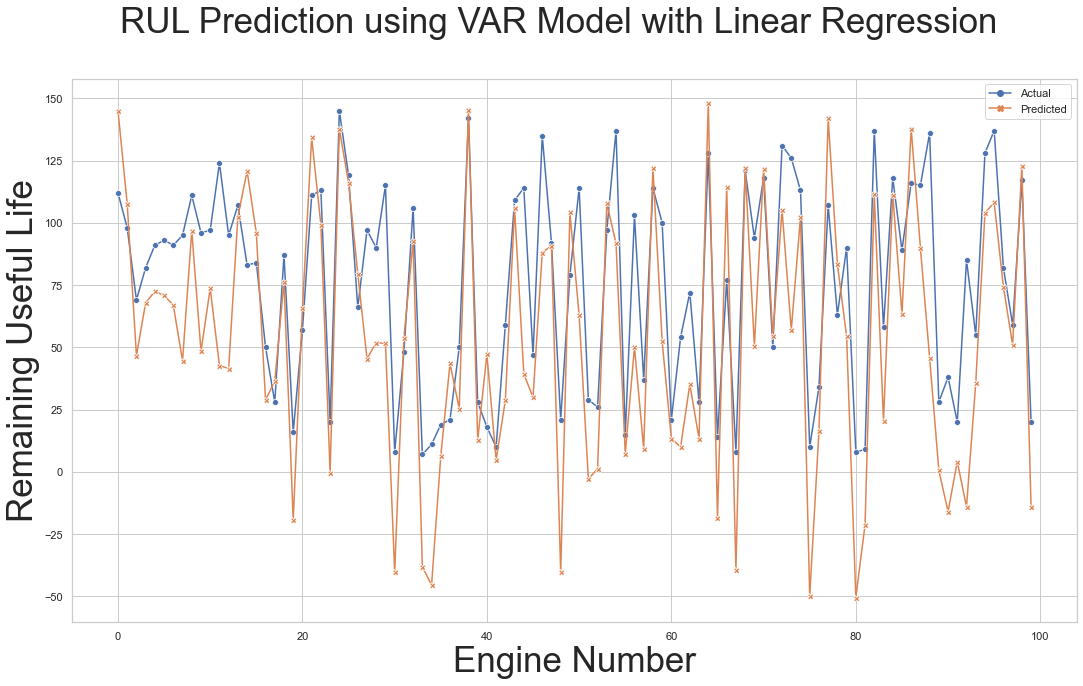

In [62]:
df=pd.DataFrame(np.arange(1,101))
df['Actual']=y_test
df['Predicted']=lin_pred
df=df.drop([0],axis=1)

sns.set_theme(style="whitegrid")
a4_dims = (18,10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df,markers=True, dashes=False)

fig.suptitle('RUL Prediction using VAR Model with Linear Regression', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)

# 3. Random Forest with VAR

100
100


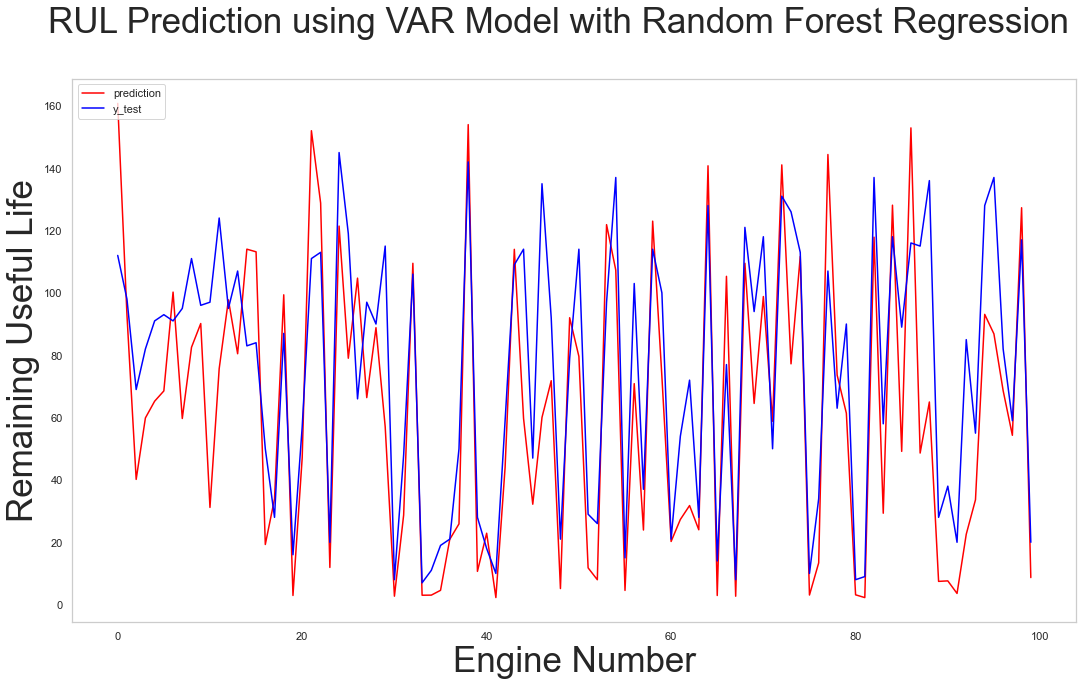

(100, 1)
mean_squared_error >>  788.573529
root_mean_squared_error >>  28.08155139945085
mean_absolute_error >> 22.372300000000006
scoring function >> 1986.474464532607


In [63]:
forest_pred = []
for i in range(100):
    forest_pred.append(forest_model.predict(predictions[i]))

forest_pred = np.array(forest_pred)

print(len(forest_pred))

y_test = np.array(df_test_rul)

print(len(y_test))
forest_pred = forest_pred.reshape((100,1))

fig = plt.figure(figsize=(18,10))
plt.plot(forest_pred,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')

fig.suptitle('RUL Prediction using VAR Model with Random Forest Regression', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)

plt.legend(loc='upper left')
plt.grid()
plt.show()

def scoring_function(actual,predicted):
    d = []
    for i in range(len(predicted)):
        d.append((predicted[i] - actual[i]))
    scores = []
    for i in range(len(d)):
        if d[i] >= 0:
            scores.append(math.exp(d[i]/10) - 1)
        else :
            scores.append(math.exp((-1*d[i])/13) - 1)
    return sum(scores)


print(forest_pred.shape)

print("mean_squared_error >> ", mean_squared_error(y_test,forest_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,forest_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_test,forest_pred))
print("scoring function >>",scoring_function(y_test,forest_pred))

Text(0, 0.5, 'Remaining Useful Life')

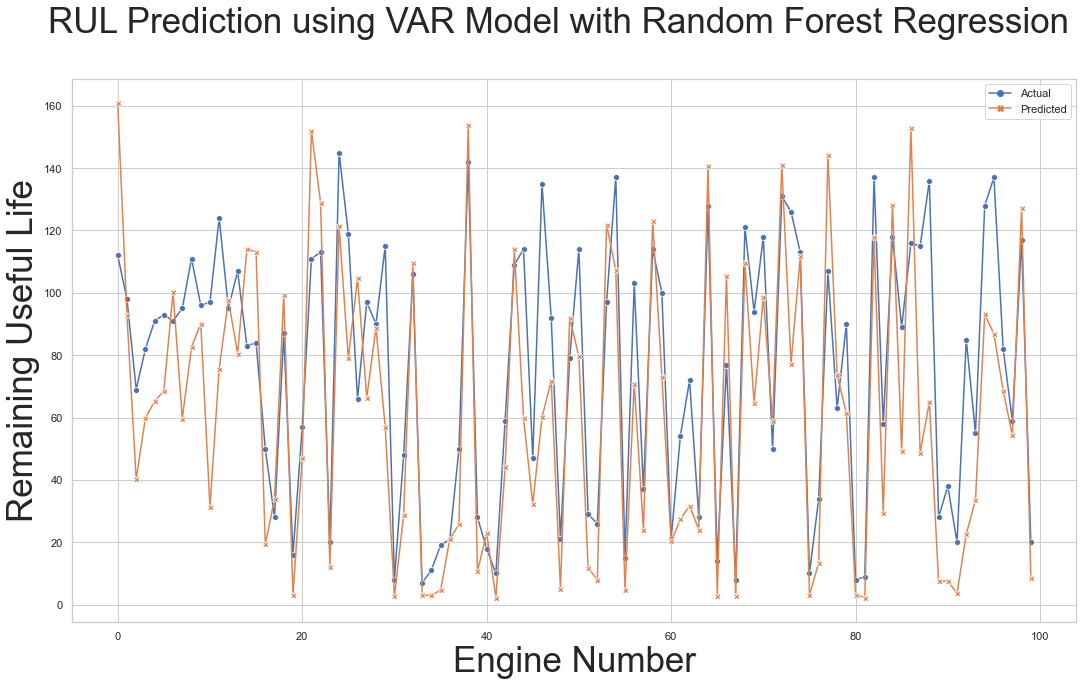

In [64]:
df=pd.DataFrame(np.arange(1,101))
df['Actual']=y_test
df['Predicted']=forest_pred
df=df.drop([0],axis=1)

sns.set_theme(style="whitegrid")
a4_dims = (18,10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df,markers=True, dashes=False)

fig.suptitle('RUL Prediction using VAR Model with Random Forest Regression', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)